# <center style='color:lightcoral'> Classify `CIFAR100` images using pretrained `ResNet` with PyTorch </center> 

## 1. Import the libraries

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.functional as F

import torchvision
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms

from torchinfo import summary

import numpy as np
import matplotlib.pyplot as plt

## 2. Define the device

In [3]:
print('PyTorch version:', torch.__version__, '\n')
print('Torchvision version:', torchvision.__version__, '\n')

#check for cuda/mps or default to cpu
if torch.backends.mps.is_available():
    device = 'mps'
elif torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
print('Device is:', device, '\n')


PyTorch version: 2.5.1+cu118 

Torchvision version: 0.20.1+cu118 

Device is: cuda 



## 3. Apply transformation

In [4]:
transform = transforms.Compose([transforms.Resize((224, 224)), 
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])])

In [5]:
weights = models.ResNet34_Weights.DEFAULT
weights.transforms()

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

## 4. Load `CIFAR100` dataset

In [6]:
training_dataset = datasets.CIFAR100('./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR100('./data', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [7]:
# check the length of training and test datasets

print('Length of the training dataset:', len(training_dataset))
print('Length of the test dataset:', len(test_dataset))

Length of the training dataset: 50000
Length of the test dataset: 10000


#### In total, there are `50000 images` in the `training set` and `10000 images` in the `test set`.

In [8]:
# check the shape of training and test datasets

print('Shape of the training dataset:', training_dataset.data.shape)
print('Shape of the test dataset:', test_dataset.data.shape)

Shape of the training dataset: (50000, 32, 32, 3)
Shape of the test dataset: (10000, 32, 32, 3)


Shape: (total images, height, width, channels)

#### The `spatial dimension` of the `color images` in the `CIFAR100 dataset` is `32x32` pixels.

In [9]:
classes = training_dataset.classes

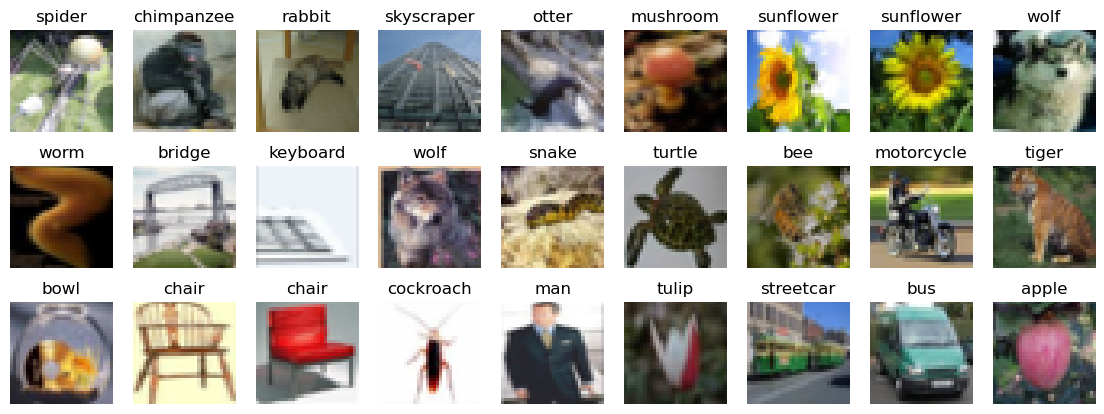

In [9]:
# show 27 randomly selected samples from the training dataset

fig, axis = plt.subplots(nrows=3, ncols=9, figsize=(14, 5))

for ax, _ in zip(axis.ravel(), range(27)):
    inx = np.random.randint(len(training_dataset))
    ax.imshow(training_dataset.data[inx])
    ax.set_title(classes[training_dataset.targets[inx]], fontsize=12)
    ax.axis(False);

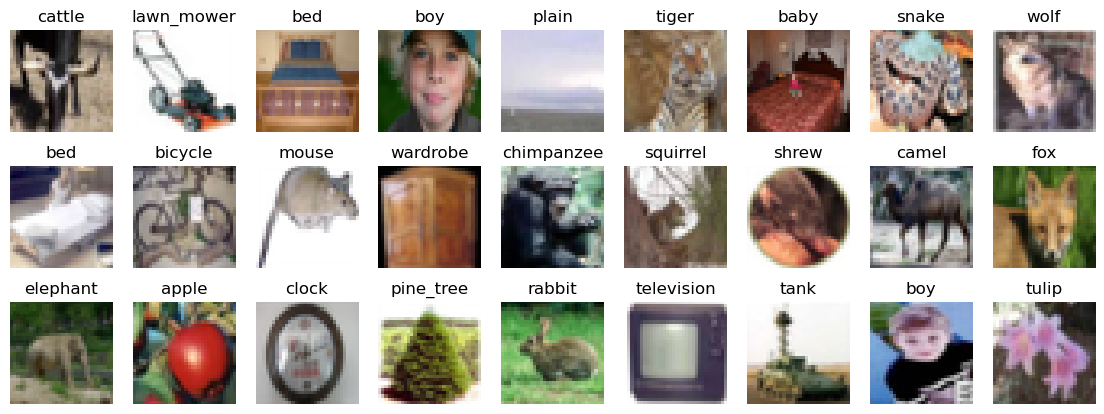

In [10]:
# show 27 randomly selected samples from the test dataset

fig, axis = plt.subplots(nrows=3, ncols=9, figsize=(14, 5))

for ax, _ in zip(axis.ravel(), range(27)):
    inx = np.random.randint(len(test_dataset))
    ax.imshow(test_dataset.data[inx])
    ax.set_title(classes[test_dataset.targets[inx]], fontsize=12)
    ax.axis(False);

## 5. Define dataloaders

In [10]:
training_dataloader = DataLoader(training_dataset, batch_size=32, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, drop_last=True)

In [11]:
# check the length of training and test dataloaders

print('Length of the training dataloader:', len(training_dataloader))
print('Length of the test dataloader:', len(test_dataloader))

Length of the training dataloader: 1562
Length of the test dataloader: 312


Since, neither 50000 nor 10000 is divisible by 32; the last batch will not have 32 images in it and hence I dropped it. 1562 and 312 are showing the number of batches in training and test dataloaders, respectively.

#### Dataloader converts a dataset into an iterable.

## 8. Modified pretrained network (`modified_ResNet34`) architecture for `CIFAR100` images

In [ ]:
modified_ResNet34 = models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1)
for param in modified_ResNet34.parameters():
    param.requires_grad = False
    
modified_ResNet34.classifier = nn.Sequential()
# Replace the classifier and ensure its parameters require gradients
modified_ResNet34.fc = nn.Sequential(
    nn.Dropout(p=0.4, inplace=True),
    nn.Linear(in_features=512, out_features=100)  # Adjust in_features based on ResNet34's architecture
)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to C:\Users\andyw/.cache\torch\hub\checkpoints\resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:03<00:00, 23.2MB/s]


## 9. Visualize the modified pretrained model (`modified_ResNet34`) architecture

In [13]:
modified_model = modified_ResNet34.to(device)
summary(modified_model, input_size=(32, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [32, 100]                 --
├─Conv2d: 1-1                            [32, 64, 112, 112]        (9,408)
├─BatchNorm2d: 1-2                       [32, 64, 112, 112]        (128)
├─ReLU: 1-3                              [32, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [32, 64, 56, 56]          --
├─Sequential: 1-5                        [32, 64, 56, 56]          --
│    └─BasicBlock: 2-1                   [32, 64, 56, 56]          --
│    │    └─Conv2d: 3-1                  [32, 64, 56, 56]          (36,864)
│    │    └─BatchNorm2d: 3-2             [32, 64, 56, 56]          (128)
│    │    └─ReLU: 3-3                    [32, 64, 56, 56]          --
│    │    └─Conv2d: 3-4                  [32, 64, 56, 56]          (36,864)
│    │    └─BatchNorm2d: 3-5             [32, 64, 56, 56]          (128)
│    │    └─ReLU: 3-6                    [32, 64, 56, 56]  

In [14]:
modified_model.parameters

<bound method Module.parameters of ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


## 10. Define the training batch

In [15]:
def training_batch(data, labels, model, criterion, optimizer):
    model.train()
    data = data.to(device)
    labels = labels.to(device)
    output = model(data)
    loss = criterion(output, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss

## 11. Define the test batch

In [16]:
with torch.inference_mode():
    def test_batch(data, labels, model, criterion):
        model.eval()
        data = data.to(device)
        labels = labels.to(device)
        output = model(data)
        loss = criterion(output, labels)
        return loss

## 12. Define the accuracy function

In [17]:
with torch.inference_mode():
    def accuracy(data, labels, model):
        model.eval()
        data = data.to(device)
        labels = labels.to(device)
        output = model(data)
        _, pred_labels = output.max(-1)
        correct = (pred_labels == labels)
        return correct.cpu().detach().numpy().tolist()

## 13. Set up model_to_train (`modified_EfficientNetV2L`), criterion (`loss function`) and optimizer

In [18]:
model_to_train = modified_ResNet34.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_to_train.parameters(), lr=0.01)

## 14. Train the model

In [ ]:
import warnings
warnings.filterwarnings("ignore")


best_model_path = 'ouput/resnet_34_best_model.pth'

from tqdm import tqdm

np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

n_epochs = 25

training_loss, test_loss = [], []
training_accuracy, test_accuracy = [], []

for epoch in range(n_epochs):
    training_losses, test_losses = [], []
    training_accuracies, test_accuracies = [], []
    
    train_bar = tqdm(training_dataloader, desc=f"Training Epoch {epoch+1}/{n_epochs}")
    for data, labels in train_bar:
        trng_batch_loss = training_batch(data, labels, model_to_train, criterion, optimizer)
        training_losses.append(trng_batch_loss.item())
        trng_batch_correct = accuracy(data, labels, model_to_train)
        training_accuracies.extend(trng_batch_correct)
        train_bar.set_postfix(loss=f"{trng_batch_loss.item():.4f}", accuracy=f"{np.mean(trng_batch_correct):.4f}")
    training_per_epoch_loss = np.array(training_losses).mean()
    training_per_epoch_accuracy = np.mean(training_accuracies)

    
     
    test_bar = tqdm(test_dataloader, desc=f"Testing Epoch {epoch+1}/{n_epochs}")
    for data, labels in test_bar:
        tst_batch_loss = test_batch(data, labels, model_to_train, criterion)
        test_losses.append(tst_batch_loss.item())
        tst_batch_correct = accuracy(data, labels, model_to_train)
        test_accuracies.extend(tst_batch_correct)
        test_bar.set_postfix(loss=f"{tst_batch_loss.item():.4f}", accuracy=f"{np.mean(tst_batch_correct):.4f}")
    test_per_epoch_loss = np.array(test_losses).mean()
    test_per_epoch_accuracy = np.mean(test_accuracies)
    
    training_loss.append(training_per_epoch_loss)
    training_accuracy.append(training_per_epoch_accuracy)
    test_loss.append(test_per_epoch_loss)
    test_accuracy.append(test_per_epoch_accuracy)
    
    print(f'Epoch: {epoch+1}/{n_epochs}\t| Training loss: {training_per_epoch_loss:.4f} | ', end='')
    print(f'Training accuracy: {training_per_epoch_accuracy:.4f} | Test loss: {test_per_epoch_loss:.4f} | ', end='')
    print(f'Test accuracy: {test_per_epoch_accuracy:.4f}')

    # Save the best model
    if test_per_epoch_accuracy > best_test_accuracy:
        best_test_accuracy = test_per_epoch_accuracy
        torch.save(model_to_train.state_dict(), best_model_path)
        print(f"Best model saved with accuracy: {best_test_accuracy:.4f}")

Testing Epoch 1/15: 100%|██████████| 312/312 [00:28<00:00, 10.90it/s, accuracy=0.4688, loss=1.8216]


Epoch: 1/15	| Training loss: 1.7858 | Training accuracy: 0.6443 | Test loss: 1.5900 | Test accuracy: 0.5800


Testing Epoch 2/15: 100%|██████████| 312/312 [00:28<00:00, 10.79it/s, accuracy=0.4688, loss=1.7254]


Epoch: 2/15	| Training loss: 1.8918 | Training accuracy: 0.6480 | Test loss: 1.5513 | Test accuracy: 0.5873


Testing Epoch 3/15: 100%|██████████| 312/312 [00:28<00:00, 10.90it/s, accuracy=0.4688, loss=1.6593]


Epoch: 3/15	| Training loss: 1.9418 | Training accuracy: 0.6549 | Test loss: 1.5245 | Test accuracy: 0.5910


Testing Epoch 4/15: 100%|██████████| 312/312 [00:28<00:00, 10.85it/s, accuracy=0.5000, loss=1.7037]


Epoch: 4/15	| Training loss: 1.9182 | Training accuracy: 0.6607 | Test loss: 1.5131 | Test accuracy: 0.5905


Testing Epoch 5/15: 100%|██████████| 312/312 [00:29<00:00, 10.65it/s, accuracy=0.4375, loss=1.7905]


Epoch: 5/15	| Training loss: 1.8904 | Training accuracy: 0.6636 | Test loss: 1.4997 | Test accuracy: 0.5930


Testing Epoch 6/15: 100%|██████████| 312/312 [00:29<00:00, 10.59it/s, accuracy=0.4688, loss=1.7687]


Epoch: 6/15	| Training loss: 1.8819 | Training accuracy: 0.6661 | Test loss: 1.4963 | Test accuracy: 0.5933


Testing Epoch 7/15: 100%|██████████| 312/312 [00:28<00:00, 10.84it/s, accuracy=0.4062, loss=1.8276]


Epoch: 7/15	| Training loss: 1.8657 | Training accuracy: 0.6691 | Test loss: 1.4778 | Test accuracy: 0.5988


Testing Epoch 8/15: 100%|██████████| 312/312 [00:28<00:00, 10.86it/s, accuracy=0.5312, loss=1.6914]


Epoch: 8/15	| Training loss: 1.8549 | Training accuracy: 0.6707 | Test loss: 1.4649 | Test accuracy: 0.6013


Testing Epoch 9/15: 100%|██████████| 312/312 [00:28<00:00, 10.83it/s, accuracy=0.4375, loss=1.6737]


Epoch: 9/15	| Training loss: 1.8515 | Training accuracy: 0.6721 | Test loss: 1.4734 | Test accuracy: 0.5995


Testing Epoch 10/15: 100%|██████████| 312/312 [00:29<00:00, 10.70it/s, accuracy=0.4375, loss=1.7583]


Epoch: 10/15	| Training loss: 1.8517 | Training accuracy: 0.6734 | Test loss: 1.4608 | Test accuracy: 0.6041


Testing Epoch 11/15: 100%|██████████| 312/312 [00:28<00:00, 10.78it/s, accuracy=0.4688, loss=1.7266]


Epoch: 11/15	| Training loss: 1.8444 | Training accuracy: 0.6763 | Test loss: 1.4562 | Test accuracy: 0.6036


Testing Epoch 12/15: 100%|██████████| 312/312 [00:29<00:00, 10.44it/s, accuracy=0.4375, loss=1.8379]


Epoch: 12/15	| Training loss: 1.8415 | Training accuracy: 0.6765 | Test loss: 1.4501 | Test accuracy: 0.6037


Testing Epoch 13/15: 100%|██████████| 312/312 [00:29<00:00, 10.49it/s, accuracy=0.5000, loss=1.8090]


Epoch: 13/15	| Training loss: 1.8352 | Training accuracy: 0.6769 | Test loss: 1.4479 | Test accuracy: 0.6011


Testing Epoch 14/15: 100%|██████████| 312/312 [00:29<00:00, 10.48it/s, accuracy=0.4062, loss=1.7668]


Epoch: 14/15	| Training loss: 1.8215 | Training accuracy: 0.6771 | Test loss: 1.4615 | Test accuracy: 0.5955


Testing Epoch 15/15: 100%|██████████| 312/312 [00:29<00:00, 10.62it/s, accuracy=0.4062, loss=1.8158]

Epoch: 15/15	| Training loss: 1.8341 | Training accuracy: 0.6798 | Test loss: 1.4409 | Test accuracy: 0.6020


## 15. Plot model loss and accuracy

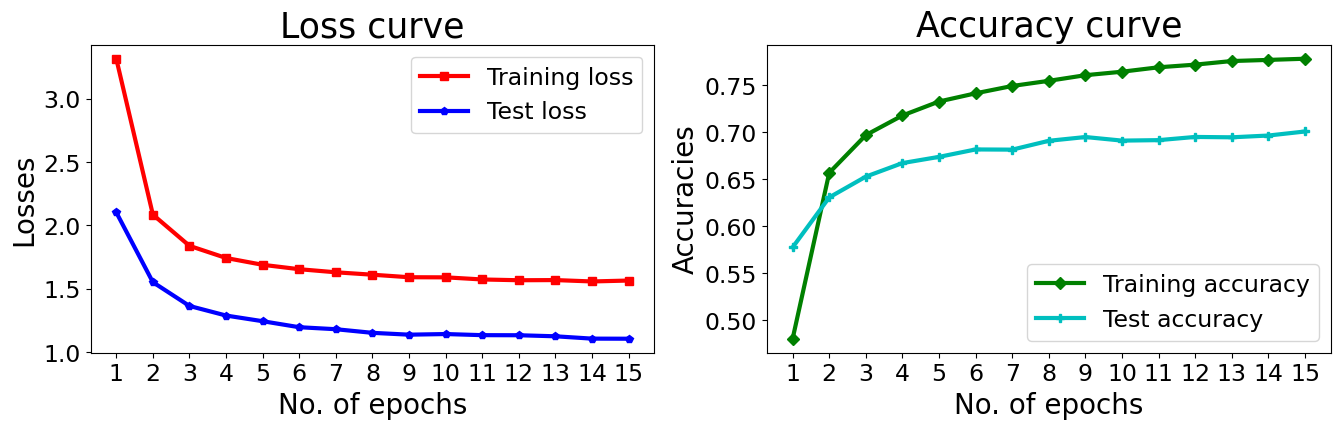

In [24]:
N = np.arange(n_epochs) + 1

fig = plt.figure(figsize=(16, 4))

fig.add_subplot(1, 2, 1)
plt.plot(N, training_loss, 'r-s', linewidth=3, label='Training loss')
plt.plot(N, test_loss, 'b-p', linewidth=3, label='Test loss')
plt.title('Loss curve', fontsize=25)
plt.xlabel('No. of epochs', fontsize=20)
plt.ylabel('Losses', fontsize=20)
plt.xticks(N, fontsize=17)
plt.yticks(fontsize=17)
plt.legend(fontsize=17)

fig.add_subplot(1, 2, 2)
plt.plot(N, training_accuracy, 'g-D', linewidth=3, label='Training accuracy')
plt.plot(N, test_accuracy, 'c-P', linewidth=3, label='Test accuracy')
plt.title('Accuracy curve', fontsize=25)
plt.xlabel('No. of epochs', fontsize=20)
plt.ylabel('Accuracies', fontsize=20)
plt.xticks(N, fontsize=17)
plt.yticks(fontsize=17)
plt.legend(fontsize=17);

# Export PyTorch Model to ONNX

In [ ]:
torch_model = model_to_train.to(device)
# Create example inputs for exporting the model. The inputs should be a tuple of tensors.
example_inputs = (torch.randn(32, 3, 224, 224))
onnx_program = torch.onnx.export(torch_model, example_inputs, dynamo=True)

onnx_program.save("output/res_net_model.onnx")